## Imports (needs to be run only once)

In [11]:
# For the first execution, you will need to uncomment this line
# to download the SpaCy model and other necessary packages. Then you can comment it back
# !python -m spacy download fr_core_news_sm
# !python -m pip install ipynb

# MLSUM Corpus
from datasets import load_dataset

# Loading article data
import json

# Our packages
from eval.rouge_l import RougeLEval
from summ.lsa import LSASummarizer

# Our BERTScore package
from eval.bert_eval import BERT_Eval

from tqdm import tqdm

dataset = load_dataset('mlsum', 'fr')

rouge_l = RougeLEval()
lsa_summ = LSASummarizer()
bert = BERT_Eval()

Reusing dataset mlsum (/Users/josephkeenan/.cache/huggingface/datasets/mlsum/fr/1.0.0/77f23eb185781f439927ac2569ab1da1083195d8b2dab2b2f6bbe52feb600688)


## Summarize a single article

In [32]:
# Pick an article and its reference summary
article = dataset['test']['text'][54]
ref_summ = dataset['test']['summary'][54]

# Computes the summary and evaluation
gen_summ = lsa_summ.get_summary(article)
scores1, scores2 = rouge_l.evaluate_one(ref_summ, gen_summ)
print(gen_summ[0])
print()
print(gen_summ[1])
print()
print(ref_summ)
print()
print(scores1)
print(scores2)

Douze personnes ont été abattues vendredi 31 mai par un tireur dans un bâtiment municipal de Virginia Beach (Etat de Virginie), station balnéaire de la côte est américaine.

personne abattre vendredi 31 mai tireur bâtiment municipal Virginia Beach etat Virginie station balnéaire côte américain

Le suspect principal, un employé des services de la ville, a tiré « à l’aveugle ». Il est lui aussi décédé.

{'rougeL': Score(precision=0.125, recall=0.19047619047619047, fmeasure=0.1509433962264151)}
{'rougeL': Score(precision=0.05, recall=0.1, fmeasure=0.06666666666666667)}


## Summarize a series of articles

In [51]:
texts = dataset['test']['text']
ref_summs = dataset['test']['summary']

# Here we pick 5 articles
gen_summs = []
for text in tqdm(texts[:5]):
    gen_summs.append(lsa_summ.get_summary(text))

scores1, scores2 = rouge_l.evaluate_many(ref_summs, gen_summs, 5)
results = rouge_l.get_results(scores1, scores2)

for k, v in results.items():
    print(k.ljust(25), round(v*100, 3), '%')

100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 65.95it/s]

Long precision avg        17.492 %
Long recall avg           19.398 %
Long F1-score avg         18.039 %
Keyword precision avg     7.417 %
Keyword recall avg        10.348 %
Keyword F1-score avg      8.307 %


#### Optional: Save generated summaries to file

In [24]:
with open('generated.txt', 'w') as f:
    for summ1, summ2 in tqdm(gen_summs):
        f.write(summ1)
        f.write('\n\n')
        f.write(summ2)
        f.write('\n\n')

100%|████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<?, ?it/s]


## Summarize a series of scraped articles

In [5]:
with open('data/actu_preliminary.json', 'r', encoding='utf-8') as jsonfile:
    data = json.load(jsonfile)

texts = [article['text'] for article in data]
ref_summs = [article['summary'] for article in data]

gen_summs = []
for text in tqdm(texts):
    gen_summs.append(lsa_summ.get_summary(text))

scores1, scores2 = rouge_l.evaluate_many(ref_summs, gen_summs)
results = rouge_l.get_results(scores1, scores2)

for k, v in results.items():
    print(k.ljust(25), round(v*100, 3), '%')

100%|███████████████████████████████████████████| 47/47 [01:21<00:00,  1.73s/it]


Implementation of BERTScore

In [12]:
long_summs, short_summs, ref_summs, key_ref_sums =  bert.split_summs(gen_summs, ref_summs)

In [13]:
bert.bert_score(long_summs, short_summs, ref_summs, key_ref_sums)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


calculating scores...
computing bert embedding.



computing greedy matching.



done in 18.04 seconds, 2.61 sentences/sec


{'Long precision avg': tensor(0.5118),
 'Long recall avg': tensor(0.5565),
 'Long F1-score avg': tensor(0.5337)}

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


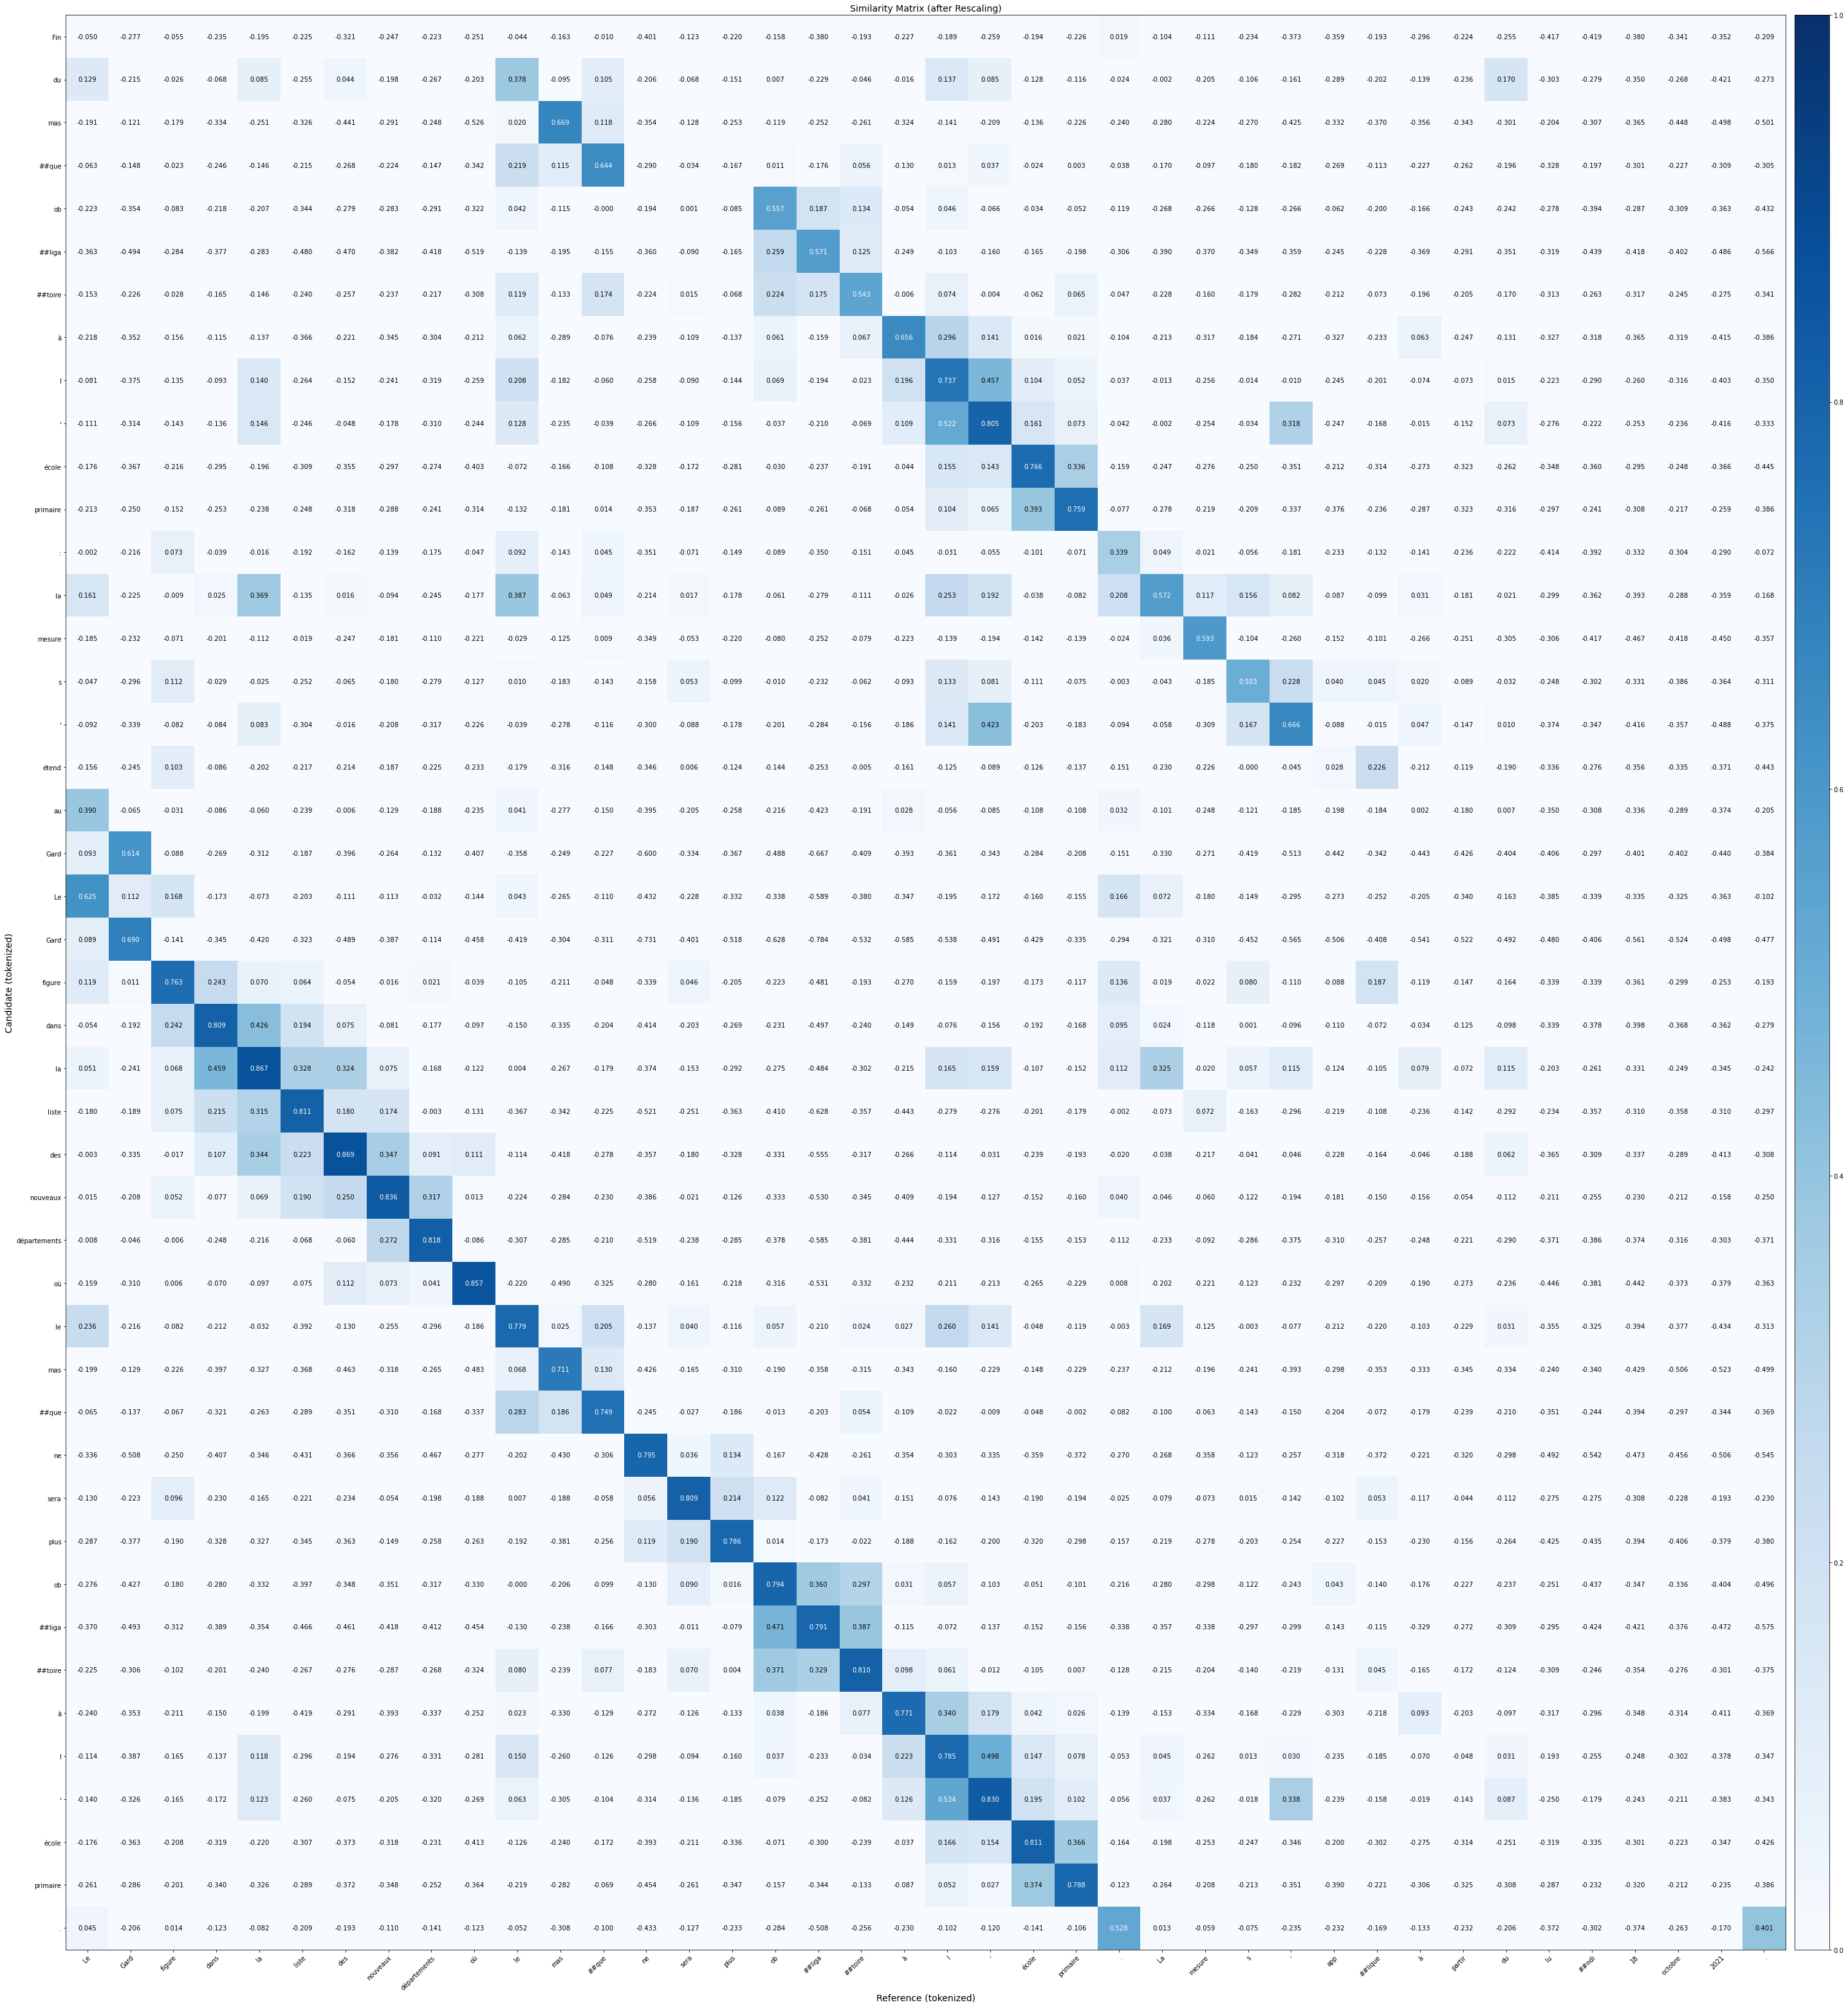

In [14]:
bert.get_matrix(long_summs, ref_summs, 4)